# Построение логистической регрессии в Python
Логистическая регрессия — это алгоритм классификации машинного обучения, используемый для прогнозирования вероятности категориальной зависимой переменной. В логистической регрессии зависимая переменная является бинарной переменной, содержащей данные, закодированные как 1 (да, успех и т.п.) или 0 (нет, провал и т.п.). Другими словами, модель логистической регрессии предсказывает P(Y=1) как функцию X.

Условия логистической регрессии

•	Бинарная логистическая регрессия требует, чтобы зависимая переменная также была бинарной.

•	Для бинарной регрессии фактор уровня 1 зависимой переменной должен представлять желаемый вывод.

•	Использоваться должны только значимые переменные.

•	Независимые переменные должны быть независимы друг от друга. Это значит, что модель должна иметь малую мультиколлинеарность или не иметь её вовсе.

•	Независимые переменные связаны линейно с логарифмическими коэффициентами.

•	Логистическая регрессия требует больших размеров выборки.

Держа в уме все перечисленные условия, давайте взглянем на наш набор данных.

In [213]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

## Данные
Набор данных взят с [репозитория машинного обучения UCI](http://archive.ics.uci.edu/ml/index.php) и относится к прямым маркетинговым кампаниям (телефонный обзвон) португальского банковского учреждения. Цель классификации в прогнозировании успеха подписки клиента (1/0) на срочный депозит (переменная y). 

In [214]:
data = pd.read_csv('banking.csv', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


Эти данные предоставляют информацию о клиентах банка, которая включает 41,188 записей и 21 поле.

In [215]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


#### Вводные переменные

1.	age — возраст (число);

2.	job — вид должности (категории: “admin” (администратор), “blue-collar” (рабочий), “entrepreneur” (мелкий предприниматель), “housemaid” (горничная), “management” (руководитель), “retired” (на пенсии), “self-employed” (самозанятый), “services” (сфера услуг), “student” (учащийся), “technician” (техник), “unemployed” (не трудоустроен), “unknown” (неизвестно));

3.	marital — семейное положение (категории: “divorced” (разведён), “married” (замужем/женат), “single” (холост/не замужем), “unknown” (неизвестно));

4.	education — образование (категории: “basic.4y”, “basic.6y”, “basic.9y” (базовое), “high.school” (высшая школа), “illiterate” (без образования), “professional.course” (профессиональные курсы), “university.degree” (университетская степень), “unknown” (неизвестно));

5.	default — имеет ли просроченные кредиты (категории: “no” (нет), “yes” (да), “unknown” (неизвестно));

6.	housing — имеет ли жилищный кредит (категории: “no” (нет), “yes” (да), “unknown” (неизвестно));

7.	loan — имеет ли личный кредит (категории: “no” (нет), “yes” (да), “unknown” (неизвестно));

8.	contact — вид связи (категории: “cellular” (мобильный), “telephone” (стационарный));

9.	month — месяц последнего обращения (категории: “jan” (январь), “feb” (февраль), “mar” (март), …, “nov” (ноябрь), “dec” (декабрь));

10.	day_of_week — день недели последнего обращения (категории: “mon” (понедельник), “tue” (вторник), “wed” (среда), “thu” (четверг), “fri” (пятница));

11.	duration — продолжительность последнего обращения в секундах (число). Важно: этот атрибут оказывает сильное влияние на вывод (например, если продолжительность=0, тогда y=’no’). Продолжительность не известна до момента совершения звонка, а по его завершению y будет, очевидно, известна. Следовательно этот вводный параметр должен включаться только в целях эталонного тестирования, для получения же реалистичной модели прогноза его следует исключать.

12.	campaign — число обращений, установленных в процессе этой кампании и для этого клиента (представлено числом и включает последнее обращение);

13.	pdays — число дней, прошедших с момента последнего обращения к клиенту во время предыдущей кампании (число; 999 означает, что ранее обращений не было);

14.	previous — число обращений, совершённых до этой кампании (число);

15.	poutcome — итоги предыдущей маркетинговой кампании (категории: “failure” (провал), “nonexistent” (несуществующий), “success” (успех));

16.	emp.var.rate — коэффициент изменения занятости (число);

17.	cons.price.idx — индекс потребительских цен (число);

18.	cons.conf.idx — индекс потребительского доверия (число);

19.	euribor3m — 3-х месячная европейская межбанковская ставка (число);

20.	nr.employed — количество сотрудников (число).

#### Прогнозируемая переменная (желаемая цель):

y —подписался ли клиент на срочный вклад (двоично: “1” означает “Да”, “0” означает “Нет”).

Колонка образования в наборе данных имеет очень много категорий, и нам нужно сократить их для оптимизации моделирования. В этой колонке представлены следующие категории:

In [216]:
data['education'].unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

Давайте сгруппируем “basic.4y”, “basic.9y” и “basic.6y” и назовём их “basic” (базовое).

In [217]:
data['education']=np.where(data['education'] =='basic.9y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.6y', 'Basic', data['education'])
data['education']=np.where(data['education'] =='basic.4y', 'Basic', data['education'])

После группировки мы получим следующие колонки:

In [218]:
data['education'].unique()

array(['Basic', 'unknown', 'university.degree', 'high.school',
       'professional.course', 'illiterate'], dtype=object)

### Изучение данных

In [219]:
data['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

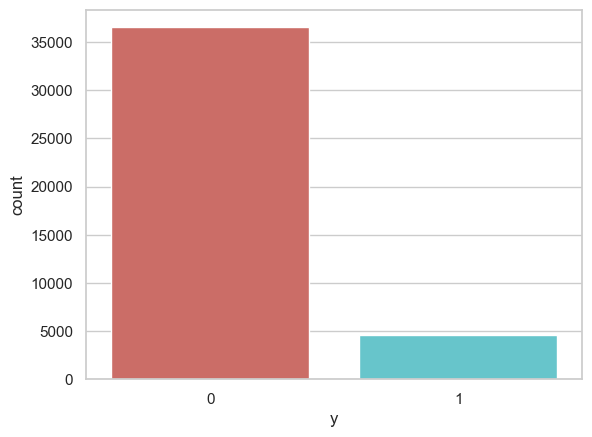

In [220]:
sns.countplot(x='y',data=data, palette='hls')
plt.show()

In [221]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("Процент не подписавшихся — ", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("Процент подписавшихся — ", pct_of_sub*100)

Процент не подписавшихся —  88.73458288821988
Процент подписавшихся —  11.265417111780131


Наши классы не сбалансированы, и соотношение не подписавшихся к подписавшимся составляет 89:11. Прежде чем мы перейдём к балансировке, давайте проведём дополнительное исследование.

In [222]:
data.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


Наблюдения:

•	Средний возраст потребителей, купивших срочный депозит, выше, чем тех, кто его не купил.

•	pdays (дни, прошедшие с момента последнего обращения к клиенту) по понятным причинам ниже для тех, кто купил депозит. Чем меньше показатель pdays, тем лучше память о последнем звонке и выше шансы успешной продажи.

•	На удивление, показатель campaigns (число обращений или звонков, сделанных во время текущей кампании) меньше для потребителей, купивших срочный депозит.

Мы можем вычислить средние категориальные значения для других категориальных переменных, вроде образования и семейного положения, чтобы получить более точное представление о данных.


In [223]:
data.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


In [224]:
data.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


In [225]:
data.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
Basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


### Визуализации

Text(0, 0.5, 'Frequency of Purchase')

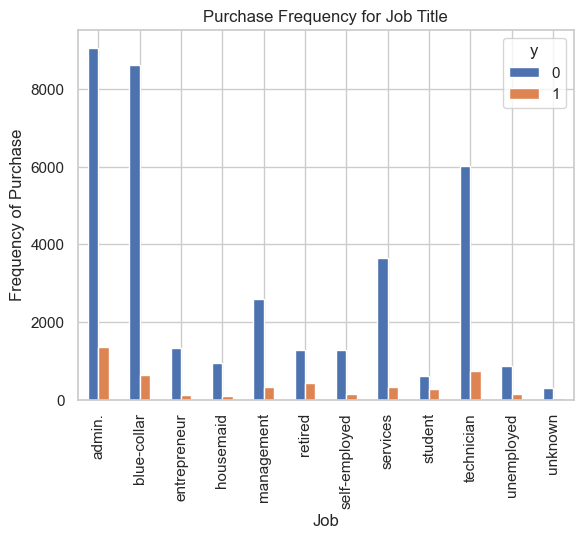

In [226]:
%matplotlib inline
pd.crosstab(data.job,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

Частота покупки депозита во многом зависит от должности клиента. Следовательно этот показатель может послужить хорошим фактором прогноза итоговой переменной.

Text(0, 0.5, 'Proportion of Customers')

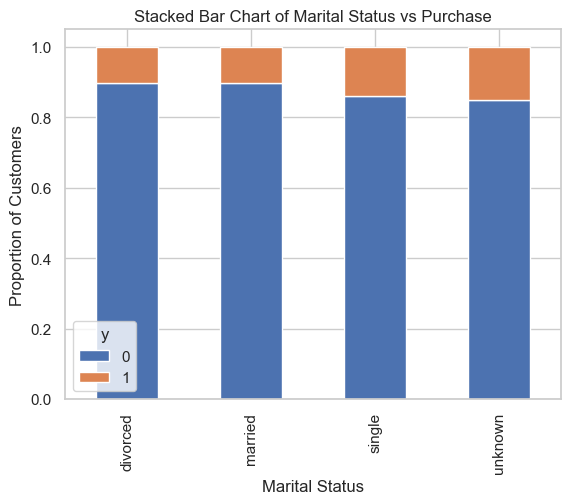

In [227]:
table=pd.crosstab(data.marital,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')

Семейное же положение не является существенным прогнозирующим фактором.

Text(0, 0.5, 'Proportion of Customers')

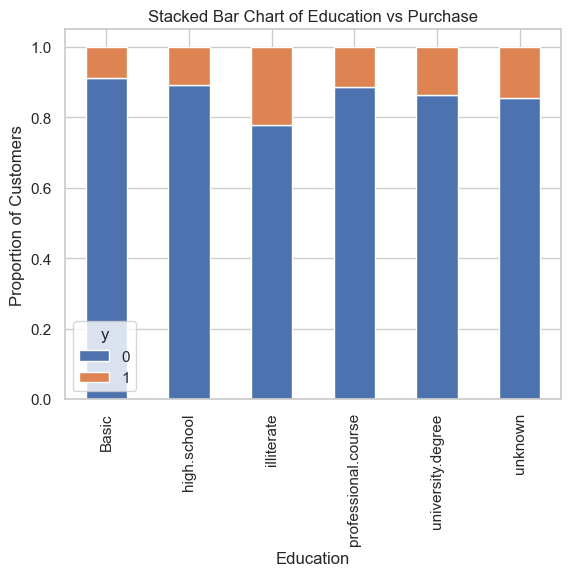

In [228]:
table=pd.crosstab(data.education,data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')

Образование выглядит хорошим фактором для прогноза итоговой переменной.

Text(0, 0.5, 'Frequency of Purchase')

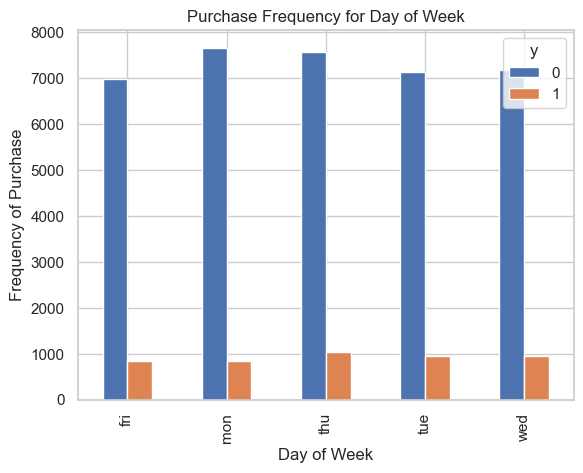

In [229]:
pd.crosstab(data.day_of_week,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')

День недели может не являться хорошим прогнозирующим фактором.

Text(0, 0.5, 'Frequency of Purchase')

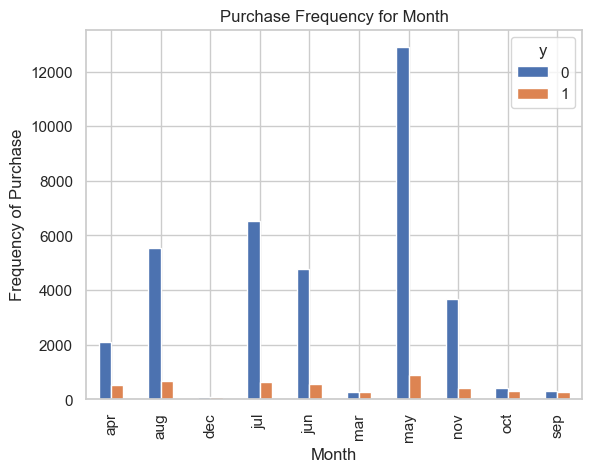

In [230]:
pd.crosstab(data.month,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')

Месяц может оказаться хорошим прогнозирующим фактором.

Text(0, 0.5, 'Frequency')

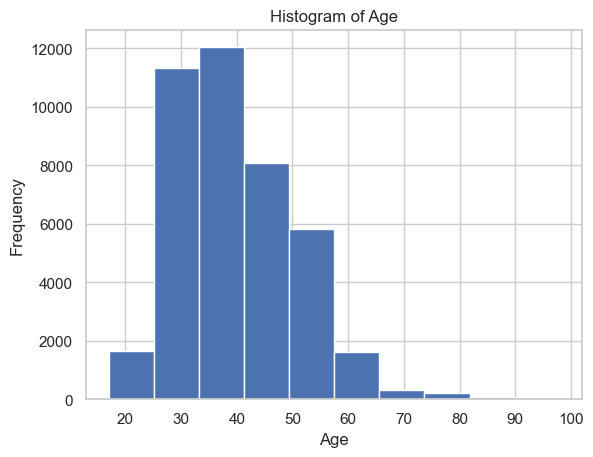

In [231]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

Большинство клиентов банка в этом наборе данных находятся в возрасте от 30 до 40 лет.

Text(0, 0.5, 'Frequency of Purchase')

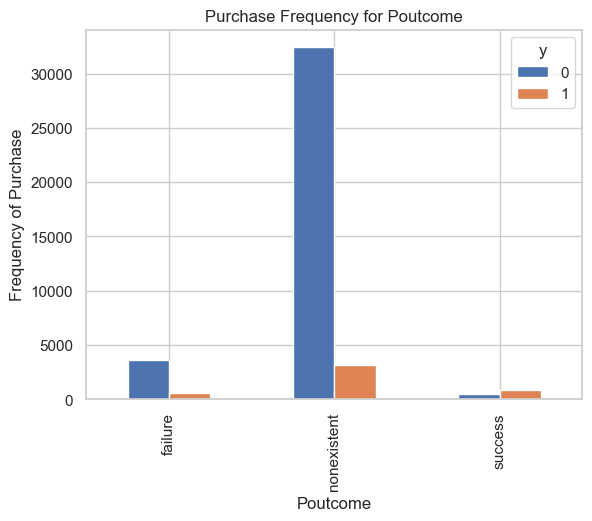

In [232]:
pd.crosstab(data.poutcome,data.y).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')

Poutcome (итоги предыдущей маркетинговой кампании) кажется хорошим прогнозирующим фактором.

### Создание индикаторных переменных

Это переменные со всего двумя значениями — ноль и единица.

Наши итоговые колонки данных будут:

In [233]:
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
    
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
data_final=data[to_keep]
data_final.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

### Over-Sampling при помощи SMOTE

После создания наших обучающих данных я увеличу частоту выборки не подписавшихся, используя [алгоритм SMOTE](https://arxiv.org/pdf/1106.1813.pdf) (синтетическая техника дублирования примеров миноритарного класса). На высоком уровне SMOTE:

1.	создаёт синтетические образцы на основе выборок минорного класса (не подписавшихся) вместо создания их копий;

2.	случайно выбирает одного из ближайших k-соседей и использует его для создания схожих, но случайно изменённых новых сведений.

Мы будем реализовывать [SMOTE в Python](http://imbalanced-learn.org/en/stable/over_sampling.html#smote-variants).

In [234]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of subscription",len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length of oversampled data is  51134
Number of no subscription in oversampled data 25567
Number of subscription 25567
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [235]:
X = data_final.loc[:, data_final.columns != 'y']
y = data_final.loc[:, data_final.columns == 'y']

### Рекурсивное устранение признаков

[Рекурсивное устранение признаков](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) (RFE) основывается на повторяющемся конструировании модели и выборе лучше всех или хуже всех выполняемого признака, отделения этого признака и повторения цикла с оставшимися. Этот процесс применяется, пока в наборе данных не закончатся признаки. Цель RFE заключается в отборе признаков посредством рекурсивного рассмотрения всё меньшего и меньшего их набора.

In [236]:
data_final_vars=data_final.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

In [237]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, step = 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[False False False False False False False False False False False False
  True False  True False  True  True False  True  True False  True  True
  True False  True  True False  True  True  True False False False  True
  True  True  True  True  True  True  True False False False False False
 False  True  True False False  True  True  True  True  True  True False
 False]
[3 3 2 3 2 2 2 3 3 3 2 2 1 3 1 3 1 1 3 1 1 3 1 1 1 3 1 1 3 1 1 1 3 2 3 1 1
 1 1 1 1 1 1 2 2 3 2 3 2 1 1 3 3 1 1 1 1 1 1 3 3]


При помощи RFE мы выбрали следующие признаки: “euribor3m”, “job_blue-collar”, “job_housemaid”, “marital_unknown”, “education_illiterate”, “default_no”, “default_unknown”, “contact_cellular”, “contact_telephone”, “month_apr”, “month_aug”, “month_dec”, “month_jul”, “month_jun”, “month_mar”, “month_may”, “month_nov”, “month_oct”, “poutcome_failure”, “poutcome_success”.

In [238]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 'default_no', 'default_unknown', 
      'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

### Реализация модели

In [239]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.455664
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.343     
Dependent Variable:   y                 AIC:               46639.8230
Date:                 2022-12-13 18:08  BIC:               46816.6671
No. Observations:     51134             Log-Likelihood:    -23300.   
Df Model:             19                LL-Null:           -35443.   
Df Residuals:         51114             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m             0.1612   0.0082  19.7747 0.0000  0.1452  0.1772
job_blue-collar 

p-значения для большинства переменных меньше 0.05, за исключением всего четырёх, следовательно мы их удалим.

In [240]:
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 
      'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"] 
X=os_data_X[cols]
y=os_data_y['y']

In [241]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.547516
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.210     
Dependent Variable:   y                 AIC:               56025.3883
Date:                 2022-12-13 18:08  BIC:               56166.8635
No. Observations:     51134             Log-Likelihood:    -27997.   
Df Model:             15                LL-Null:           -35443.   
Df Residuals:         51118             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m             0.1726   0.0055  31.1231 0.0000  0.1617  0.1835
job_blue-collar 

### Обучение модели логистической регрессии

In [242]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [243]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.84


### Матрица ошибок (Confusion Matrix)

In [244]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6850  816]
 [1709 5966]]


In [245]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84      7666
           1       0.88      0.78      0.83      7675

    accuracy                           0.84     15341
   macro avg       0.84      0.84      0.83     15341
weighted avg       0.84      0.84      0.83     15341



In [246]:
### Вычисление точности, полноты, F-меры и поддержки

Точность является соотношением tp/(tp + fp), где tp является числом верно-положительных, а fp — числом ложно-положительных. Точность — это интуитивно понятная способность классификатора не помечать выборку как положительную, если она отрицательна.

Полнота— это пропорция tp/(tp +fn), где tp представляет число верно-положительных результатов, а fn — число ложно-отрицательных. Полнота является интуитивно понятной способностью классификатора находить все положительные выборки.

Показатель F-бета можно интерпретировать как взвешенное гармоническое среднее точности и полноты, где лучшим значением этого показателя будет 1, а худшим 0.

Показатель F-бета определяет, насколько значимость полноты больше, чем точности, опираясь на фактор бета. Например, beta = 1.0 означает, что полнота и точность равно важны.

Поддержка — это число вхождений каждого класса в y_test.

SyntaxError: invalid syntax (1247726139.py, line 3)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Интерпретация: из всего тестового набора 74% рекламируемых срочных депозитов понравились клиентам. Из всего тестового набора 74% клиентов предпочли рекламируемые срочные депозиты.

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

[Кривая рабочей характеристики приёмника](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)  (ROC) является ещё одним популярным инструментом, используемым с бинарными классификаторами. Пунктирная линия представляет ROC-кривую полностью случайного классификатора. Хороший классификатор остаётся от неё максимально далеко (по направлению к верхнему левому углу).